### Objective

1. Introduce the concept of SSL
2. Compare the performance on CIFAR10 dataset:
    - CNN on small labelled dataset
    - CNN on small labelled dataset + augmentation
    - CNN on small labelled dataset + SSL on large unlabelled dataset
    - CNN on small labelled dataset + SSL on large unlabelled dataset + augmentation

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

from tqdm import tqdm
import joblib
from glob import glob

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import pandas as pd
import torchsummary
%matplotlib inline
# Retina display
%config InlineBackend.figure_format = 'retina'

# Confusion matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# import timm

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load dataset

In [3]:
n_train = 1000
n_test = 20000

dataset = torchvision.datasets.CIFAR10(root="/tmp/cifardata", download=True)
transform = torchvision.models.ResNet18_Weights.DEFAULT.transforms()

X = (torch.tensor(dataset.data).float().permute(0, 3, 1, 2) / 255)
y = torch.tensor(dataset.targets).long()
print(X.shape, y.shape)
print(X.min(), X.max())

torch.manual_seed(0)
idx = torch.randperm(len(X))
train_idx = idx[:n_train]
pool_idx = idx[n_train:-n_test]
test_idx = idx[-n_test:]
print(len(train_idx), len(pool_idx), len(test_idx))

Files already downloaded and verified
torch.Size([50000, 3, 32, 32]) torch.Size([50000])
tensor(0.) tensor(1.)
1000 29000 20000


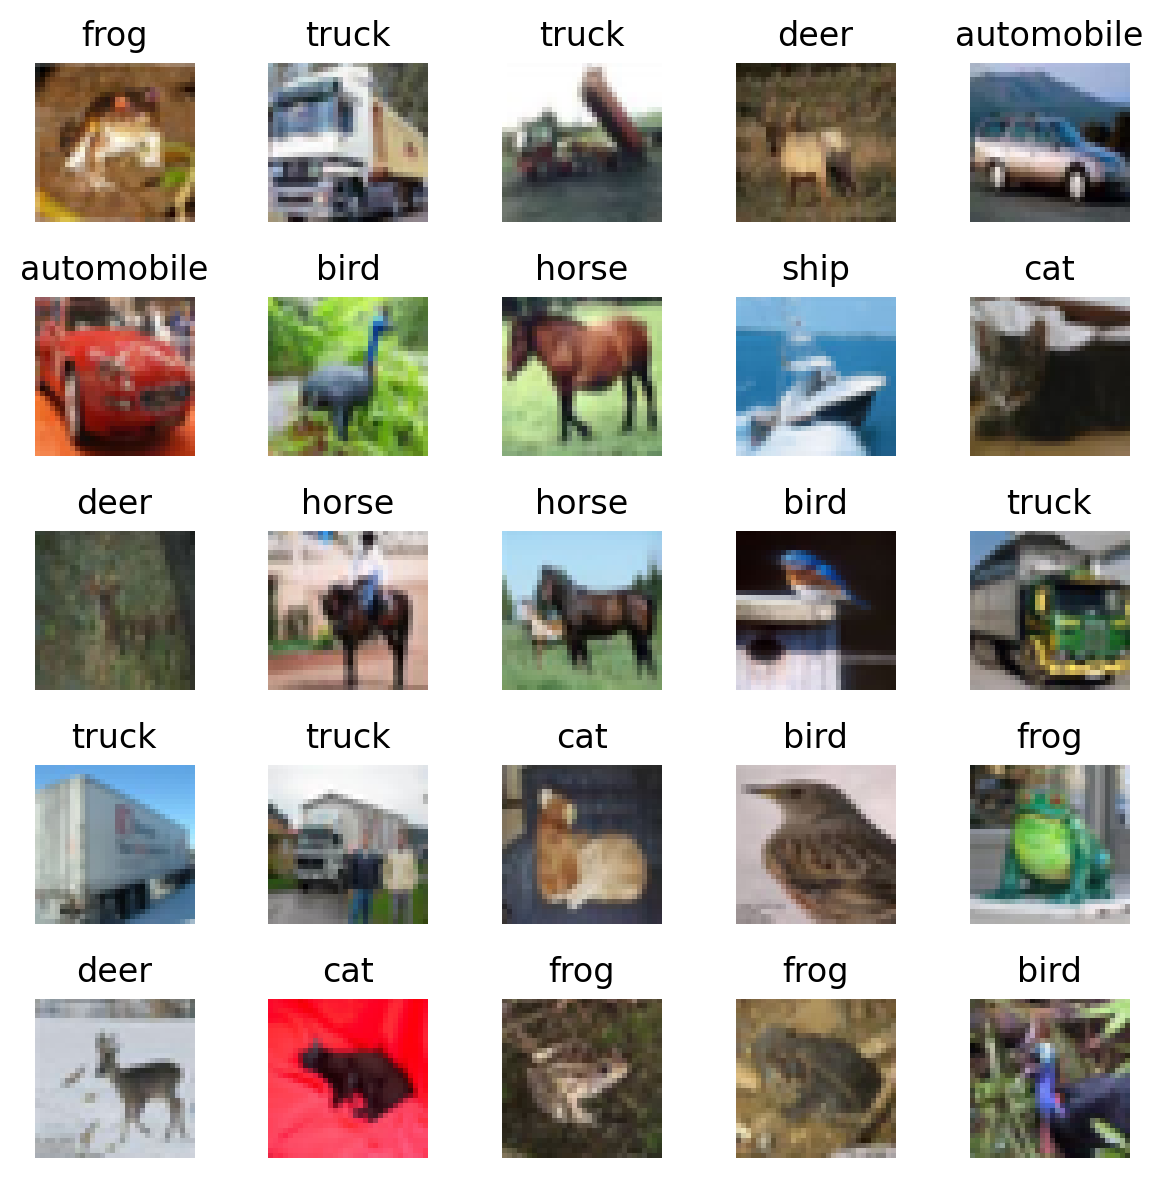

In [4]:
# Plot some images
plt.figure(figsize=(6, 6))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].cpu().permute(1, 2, 0))
    plt.axis('off')
    plt.title(dataset.classes[dataset.targets[i]])
plt.tight_layout()

## Create model

In [5]:
class Featurizer(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = torchvision.models.resnet18(weights=None)
        self.model.fc = nn.Identity() # remove the last layer
        
    def forward(self, x):
        x = self.model(x)
        return x
    
class Classifier(nn.Module):
    def __init__(self, n_classes, dropout):
        super().__init__()
        
        self.dropout = nn.Dropout(dropout, inplace=True)
        
        self.fc1 = nn.Linear(512, 256)
        self.fc2 = nn.Linear(256, n_classes)
        
    def forward(self, x):
        x = F.gelu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

## Run on train data

In [6]:
def train_fn(model, X, y, lr, batch_size, epochs, device):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    n_batches = len(X) // batch_size
    
    model.train()
    iter_losses = []
    epoch_losses = []
    for epoch in range(epochs):
        idx = torch.randperm(len(X))
        epoch_loss = 0
        pbar = tqdm(range(0, len(X), batch_size))
        for i in pbar:
            optimizer.zero_grad()
            batch_X = X[idx][i:i+batch_size].to(device)
            batch_y = y[idx][i:i+batch_size].to(device)
            logits = model(batch_X)
            loss = criterion(logits, batch_y)
            loss.backward()
            optimizer.step()
            iter_losses.append(loss.item())
            epoch_loss += loss.item()
            pbar.set_description(f"loss: {loss.item():.4f}")
        epoch_losses.append(epoch_loss / n_batches)
        print(f"Epoch {epoch+1}/{epochs} | Epoch loss: {epoch_loss / n_batches:.4f}")
        
    return iter_losses, epoch_losses

def predict_fn(model, X, batch_size, device):
    model.eval()
    with torch.no_grad():
        logits = []
        for i in tqdm(range(0, len(X), batch_size)):
            batch_X = X[i:i+batch_size].to(device)
            batch_logits = model(batch_X)
            logits.append(batch_logits.cpu())
        logits = torch.cat(logits)
    return logits

def get_classes(logits):
    return logits.argmax(-1)

In [7]:
model = nn.Sequential(
    Featurizer(),
    Classifier(n_classes=10, dropout=0.1),
).to(device)
iter_losses, epoch_losses = train_fn(model, X[train_idx], y[train_idx], lr=3e-4, batch_size=128, epochs=50, device=device)

loss: 2.0082: 100%|██████████| 8/8 [00:00<00:00, 14.15it/s]


Epoch 1/50 | Epoch loss: 2.5164


loss: 1.5314: 100%|██████████| 8/8 [00:00<00:00, 52.28it/s]


Epoch 2/50 | Epoch loss: 1.8170


loss: 0.8727: 100%|██████████| 8/8 [00:00<00:00, 48.82it/s]


Epoch 3/50 | Epoch loss: 1.0894


loss: 0.2208: 100%|██████████| 8/8 [00:00<00:00, 55.55it/s]


Epoch 4/50 | Epoch loss: 0.3871


loss: 0.0463: 100%|██████████| 8/8 [00:00<00:00, 52.33it/s]


Epoch 5/50 | Epoch loss: 0.0939


loss: 0.0155: 100%|██████████| 8/8 [00:00<00:00, 55.94it/s]


Epoch 6/50 | Epoch loss: 0.0245


loss: 0.0081: 100%|██████████| 8/8 [00:00<00:00, 51.61it/s]


Epoch 7/50 | Epoch loss: 0.0149


loss: 0.0062: 100%|██████████| 8/8 [00:00<00:00, 64.73it/s]


Epoch 8/50 | Epoch loss: 0.0090


loss: 0.0031: 100%|██████████| 8/8 [00:00<00:00, 54.99it/s]


Epoch 9/50 | Epoch loss: 0.0067


loss: 0.0068: 100%|██████████| 8/8 [00:00<00:00, 55.66it/s]


Epoch 10/50 | Epoch loss: 0.0036


loss: 0.0023: 100%|██████████| 8/8 [00:00<00:00, 46.23it/s]


Epoch 11/50 | Epoch loss: 0.0032


loss: 0.0016: 100%|██████████| 8/8 [00:00<00:00, 50.81it/s]


Epoch 12/50 | Epoch loss: 0.0016


loss: 0.0011: 100%|██████████| 8/8 [00:00<00:00, 56.12it/s]


Epoch 13/50 | Epoch loss: 0.0017


loss: 0.0010: 100%|██████████| 8/8 [00:00<00:00, 53.74it/s]


Epoch 14/50 | Epoch loss: 0.0012


loss: 0.0008: 100%|██████████| 8/8 [00:00<00:00, 53.42it/s]


Epoch 15/50 | Epoch loss: 0.0010


loss: 0.0012: 100%|██████████| 8/8 [00:00<00:00, 55.05it/s]


Epoch 16/50 | Epoch loss: 0.0010


loss: 0.0009: 100%|██████████| 8/8 [00:00<00:00, 58.56it/s]


Epoch 17/50 | Epoch loss: 0.0009


loss: 0.0006: 100%|██████████| 8/8 [00:00<00:00, 57.37it/s]


Epoch 18/50 | Epoch loss: 0.0007


loss: 0.0005: 100%|██████████| 8/8 [00:00<00:00, 48.02it/s]


Epoch 19/50 | Epoch loss: 0.0007


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 53.29it/s]


Epoch 20/50 | Epoch loss: 0.0007


loss: 0.0006: 100%|██████████| 8/8 [00:00<00:00, 54.12it/s]


Epoch 21/50 | Epoch loss: 0.0006


loss: 0.0005: 100%|██████████| 8/8 [00:00<00:00, 54.72it/s]


Epoch 22/50 | Epoch loss: 0.0006


loss: 0.0006: 100%|██████████| 8/8 [00:00<00:00, 55.24it/s]


Epoch 23/50 | Epoch loss: 0.0006


loss: 0.0005: 100%|██████████| 8/8 [00:00<00:00, 56.09it/s]


Epoch 24/50 | Epoch loss: 0.0006


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 51.08it/s]


Epoch 25/50 | Epoch loss: 0.0005


loss: 0.0006: 100%|██████████| 8/8 [00:00<00:00, 45.13it/s]


Epoch 26/50 | Epoch loss: 0.0006


loss: 0.0009: 100%|██████████| 8/8 [00:00<00:00, 49.26it/s]


Epoch 27/50 | Epoch loss: 0.0005


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 50.21it/s]


Epoch 28/50 | Epoch loss: 0.0005


loss: 0.0007: 100%|██████████| 8/8 [00:00<00:00, 48.67it/s]


Epoch 29/50 | Epoch loss: 0.0004


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 52.04it/s]


Epoch 30/50 | Epoch loss: 0.0004


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 48.28it/s]


Epoch 31/50 | Epoch loss: 0.0003


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 50.18it/s]


Epoch 32/50 | Epoch loss: 0.0004


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 49.32it/s]


Epoch 33/50 | Epoch loss: 0.0004


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 49.88it/s]


Epoch 34/50 | Epoch loss: 0.0004


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 52.91it/s]


Epoch 35/50 | Epoch loss: 0.0003


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 46.78it/s]


Epoch 36/50 | Epoch loss: 0.0003


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 47.86it/s]


Epoch 37/50 | Epoch loss: 0.0003


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 49.37it/s]


Epoch 38/50 | Epoch loss: 0.0003


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 50.26it/s]


Epoch 39/50 | Epoch loss: 0.0003


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 51.51it/s]


Epoch 40/50 | Epoch loss: 0.0003


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 52.26it/s]


Epoch 41/50 | Epoch loss: 0.0003


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 51.12it/s]


Epoch 42/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 49.33it/s]


Epoch 43/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 49.01it/s]


Epoch 44/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 46.10it/s]


Epoch 45/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 44.57it/s]


Epoch 46/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 51.97it/s]


Epoch 47/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 56.00it/s]


Epoch 48/50 | Epoch loss: 0.0002


loss: 0.0001: 100%|██████████| 8/8 [00:00<00:00, 53.08it/s]


Epoch 49/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 52.93it/s]

Epoch 50/50 | Epoch loss: 0.0002


In [8]:
pred_y = predict_fn(model, X[train_idx], batch_size=128, device=device)
pred_classes = get_classes(pred_y)
print(f"Train accuracy: {(pred_classes == y[train_idx]).float().mean().item():.4f}")
pred_y = predict_fn(model, X[pool_idx], batch_size=128, device=device)
pred_classes = get_classes(pred_y)
print(f"Pool accuracy: {(pred_classes == y[pool_idx]).float().mean().item():.4f}")
pred_y = predict_fn(model, X[test_idx], batch_size=128, device=device)
pred_classes = get_classes(pred_y)
print(f"Test accuracy: {(pred_classes == y[test_idx]).float().mean().item():.4f}")

100%|██████████| 8/8 [00:00<00:00, 318.65it/s]


Train accuracy: 1.0000


100%|██████████| 227/227 [00:00<00:00, 379.75it/s]


Pool accuracy: 0.3610


100%|██████████| 157/157 [00:00<00:00, 342.99it/s]


Test accuracy: 0.3609


## Run on train+pool data

In [9]:
# model = nn.Sequential(
#     Featurizer(),
#     Classifier(n_classes=10, dropout=0.1),
# ).to(device)

# tmp_idx = torch.cat([train_idx, pool_idx])

# iter_losses, epoch_losses = train_fn(model, X[tmp_idx], y[tmp_idx], lr=3e-4, batch_size=128, epochs=5, device=device)

In [10]:
# pred_y = predict_fn(model, X[train_idx], batch_size=128)
# print(f"Train accuracy: {(pred_y == y[train_idx]).float().mean().item():.4f}")
# pred_y = predict_fn(model, X[pool_idx], batch_size=128)
# print(f"Pool accuracy: {(pred_y == y[pool_idx]).float().mean().item():.4f}")
# pred_y = predict_fn(model, X[test_idx], batch_size=128)
# print(f"Test accuracy: {(pred_y == y[test_idx]).float().mean().item():.4f}")

## Prepare data for SSL

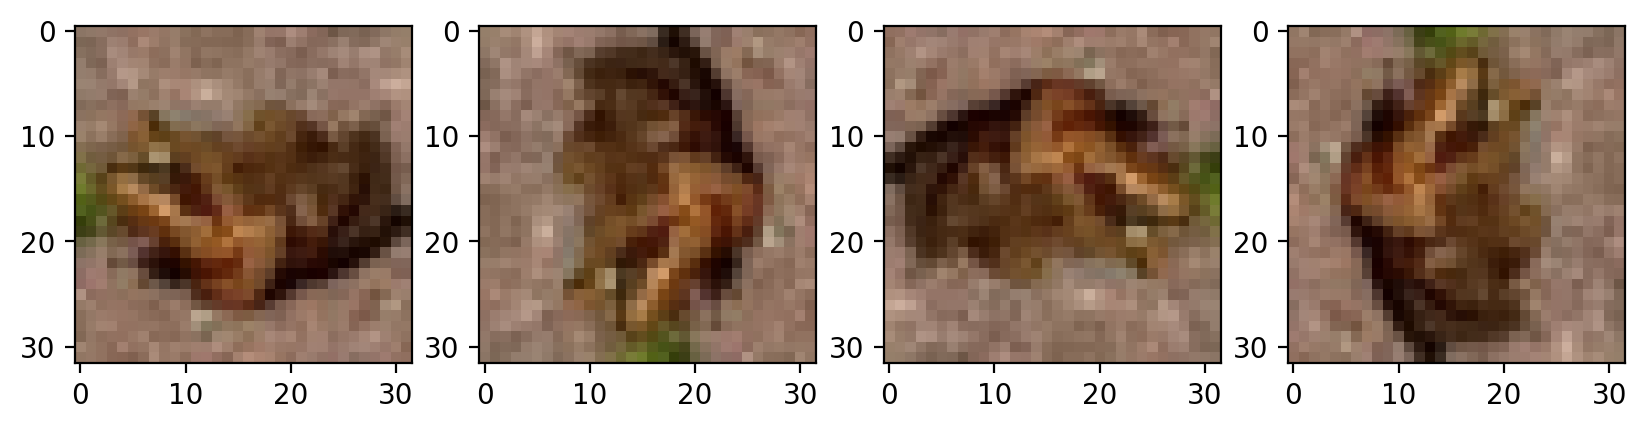

In [11]:
tmp_idx = torch.cat([train_idx, pool_idx])

train_X_0 = X[tmp_idx]
train_y_0 = torch.ones(len(train_X_0)).long() * 0
# rotate 90 degrees
train_X_90 = torch.rot90(X[tmp_idx], 1, (2, 3))
train_y_90 = torch.ones(len(train_X_90)).long() * 1
# roatet 180 degrees
train_X_180 = torch.rot90(X[tmp_idx], 2, (2, 3))
train_y_180 = torch.ones(len(train_X_180)).long() * 2
# rotate 270 degrees
train_X_270 = torch.rot90(X[tmp_idx], 3, (2, 3))
train_y_270 = torch.ones(len(train_X_270)).long() * 3

fig, ax = plt.subplots(1, 4, figsize=(10, 5))
ax.flat[0].imshow(train_X_0[0].cpu().permute(1, 2, 0))
ax.flat[1].imshow(train_X_90[0].cpu().permute(1, 2, 0))
ax.flat[2].imshow(train_X_180[0].cpu().permute(1, 2, 0))
ax.flat[3].imshow(train_X_270[0].cpu().permute(1, 2, 0))

In [12]:
ssl_X = torch.cat([train_X_0, train_X_90, train_X_180, train_X_270])
ssl_y = torch.cat([train_y_0, train_y_90, train_y_180, train_y_270])
print(ssl_X.shape, ssl_y.shape)

torch.Size([120000, 3, 32, 32]) torch.Size([120000])


In [13]:
ssl_model = nn.Sequential(
    Featurizer(),
    Classifier(n_classes=4, dropout=0.1),
).to(device)

iter_losses, epoch_losses = train_fn(ssl_model, ssl_X, ssl_y, lr=3e-4, batch_size=1024, epochs=10, device=device)

loss: 0.9418: 100%|██████████| 118/118 [00:29<00:00,  4.03it/s]


Epoch 1/10 | Epoch loss: 1.0250


loss: 0.7411: 100%|██████████| 118/118 [00:29<00:00,  3.97it/s]


Epoch 2/10 | Epoch loss: 0.8500


loss: 0.7318: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Epoch 3/10 | Epoch loss: 0.7566


loss: 0.7391: 100%|██████████| 118/118 [00:29<00:00,  4.00it/s]


Epoch 4/10 | Epoch loss: 0.6659


loss: 0.5704: 100%|██████████| 118/118 [00:29<00:00,  3.98it/s]


Epoch 5/10 | Epoch loss: 0.5858


loss: 0.4908: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Epoch 6/10 | Epoch loss: 0.4937


loss: 0.4344: 100%|██████████| 118/118 [00:29<00:00,  4.02it/s]


Epoch 7/10 | Epoch loss: 0.4129


loss: 0.3818: 100%|██████████| 118/118 [00:29<00:00,  3.95it/s]


Epoch 8/10 | Epoch loss: 0.3386


loss: 0.3941: 100%|██████████| 118/118 [00:29<00:00,  3.99it/s]


Epoch 9/10 | Epoch loss: 0.2716


loss: 0.2491: 100%|██████████| 118/118 [00:29<00:00,  4.03it/s]

Epoch 10/10 | Epoch loss: 0.2199


In [14]:
pred_y = predict_fn(ssl_model, ssl_X, batch_size=1024, device=device)
pred_classes = get_classes(pred_y)
print(f"Train accuracy: {(pred_classes == ssl_y).float().mean().item():.4f}")

100%|██████████| 118/118 [00:01<00:00, 101.97it/s]


Train accuracy: 0.8958


## Train classifier

In [15]:
model = nn.Sequential(Featurizer(), Classifier(n_classes=10, dropout=0.1)).to(device)
with torch.no_grad():
    model[0].load_state_dict(ssl_model[0].state_dict())

iter_losses, epoch_losses = train_fn(model, X[train_idx], y[train_idx], lr=3e-4, batch_size=128, epochs=50, device=device)

loss: 1.7525: 100%|██████████| 8/8 [00:00<00:00, 41.41it/s]


Epoch 1/50 | Epoch loss: 2.3521


loss: 1.1995: 100%|██████████| 8/8 [00:00<00:00, 41.54it/s]


Epoch 2/50 | Epoch loss: 1.4969


loss: 0.6658: 100%|██████████| 8/8 [00:00<00:00, 42.69it/s]


Epoch 3/50 | Epoch loss: 0.7974


loss: 0.1889: 100%|██████████| 8/8 [00:00<00:00, 45.17it/s]


Epoch 4/50 | Epoch loss: 0.3080


loss: 0.0845: 100%|██████████| 8/8 [00:00<00:00, 44.69it/s]


Epoch 5/50 | Epoch loss: 0.0920


loss: 0.0212: 100%|██████████| 8/8 [00:00<00:00, 44.36it/s]


Epoch 6/50 | Epoch loss: 0.0223


loss: 0.0073: 100%|██████████| 8/8 [00:00<00:00, 51.36it/s]


Epoch 7/50 | Epoch loss: 0.0108


loss: 0.0030: 100%|██████████| 8/8 [00:00<00:00, 50.90it/s]


Epoch 8/50 | Epoch loss: 0.0052


loss: 0.0026: 100%|██████████| 8/8 [00:00<00:00, 48.63it/s]


Epoch 9/50 | Epoch loss: 0.0030


loss: 0.0026: 100%|██████████| 8/8 [00:00<00:00, 50.12it/s]


Epoch 10/50 | Epoch loss: 0.0025


loss: 0.0016: 100%|██████████| 8/8 [00:00<00:00, 45.77it/s]


Epoch 11/50 | Epoch loss: 0.0017


loss: 0.0009: 100%|██████████| 8/8 [00:00<00:00, 46.63it/s]


Epoch 12/50 | Epoch loss: 0.0013


loss: 0.0012: 100%|██████████| 8/8 [00:00<00:00, 49.34it/s]


Epoch 13/50 | Epoch loss: 0.0012


loss: 0.0007: 100%|██████████| 8/8 [00:00<00:00, 44.09it/s]


Epoch 14/50 | Epoch loss: 0.0011


loss: 0.0008: 100%|██████████| 8/8 [00:00<00:00, 45.55it/s]


Epoch 15/50 | Epoch loss: 0.0010


loss: 0.0009: 100%|██████████| 8/8 [00:00<00:00, 47.21it/s]


Epoch 16/50 | Epoch loss: 0.0008


loss: 0.0010: 100%|██████████| 8/8 [00:00<00:00, 47.21it/s]


Epoch 17/50 | Epoch loss: 0.0009


loss: 0.0005: 100%|██████████| 8/8 [00:00<00:00, 43.20it/s]


Epoch 18/50 | Epoch loss: 0.0008


loss: 0.0009: 100%|██████████| 8/8 [00:00<00:00, 42.06it/s]


Epoch 19/50 | Epoch loss: 0.0007


loss: 0.0007: 100%|██████████| 8/8 [00:00<00:00, 46.89it/s]


Epoch 20/50 | Epoch loss: 0.0007


loss: 0.0005: 100%|██████████| 8/8 [00:00<00:00, 47.42it/s]


Epoch 21/50 | Epoch loss: 0.0006


loss: 0.0005: 100%|██████████| 8/8 [00:00<00:00, 44.79it/s]


Epoch 22/50 | Epoch loss: 0.0006


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 46.43it/s]


Epoch 23/50 | Epoch loss: 0.0005


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 45.88it/s]


Epoch 24/50 | Epoch loss: 0.0005


loss: 0.0006: 100%|██████████| 8/8 [00:00<00:00, 49.39it/s]


Epoch 25/50 | Epoch loss: 0.0005


loss: 0.0006: 100%|██████████| 8/8 [00:00<00:00, 52.26it/s]


Epoch 26/50 | Epoch loss: 0.0005


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 52.36it/s]


Epoch 27/50 | Epoch loss: 0.0004


loss: 0.0008: 100%|██████████| 8/8 [00:00<00:00, 48.01it/s]


Epoch 28/50 | Epoch loss: 0.0005


loss: 0.0005: 100%|██████████| 8/8 [00:00<00:00, 54.43it/s]


Epoch 29/50 | Epoch loss: 0.0004


loss: 0.0005: 100%|██████████| 8/8 [00:00<00:00, 52.14it/s]


Epoch 30/50 | Epoch loss: 0.0004


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 51.16it/s]


Epoch 31/50 | Epoch loss: 0.0004


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 52.39it/s]


Epoch 32/50 | Epoch loss: 0.0004


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 58.83it/s]


Epoch 33/50 | Epoch loss: 0.0003


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 47.28it/s]


Epoch 34/50 | Epoch loss: 0.0004


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 50.82it/s]


Epoch 35/50 | Epoch loss: 0.0004


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 46.96it/s]


Epoch 36/50 | Epoch loss: 0.0004


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 50.66it/s]


Epoch 37/50 | Epoch loss: 0.0003


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 53.08it/s]


Epoch 38/50 | Epoch loss: 0.0003


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 53.66it/s]


Epoch 39/50 | Epoch loss: 0.0004


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 50.06it/s]


Epoch 40/50 | Epoch loss: 0.0002


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 57.58it/s]


Epoch 41/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 47.35it/s]


Epoch 42/50 | Epoch loss: 0.0003


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 42.05it/s]


Epoch 43/50 | Epoch loss: 0.0002


loss: 0.0004: 100%|██████████| 8/8 [00:00<00:00, 52.16it/s]


Epoch 44/50 | Epoch loss: 0.0002


loss: 0.0003: 100%|██████████| 8/8 [00:00<00:00, 45.49it/s]


Epoch 45/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 47.47it/s]


Epoch 46/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 46.20it/s]


Epoch 47/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 50.31it/s]


Epoch 48/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 55.76it/s]


Epoch 49/50 | Epoch loss: 0.0002


loss: 0.0002: 100%|██████████| 8/8 [00:00<00:00, 53.05it/s]

Epoch 50/50 | Epoch loss: 0.0002


In [16]:
pred_y = predict_fn(model, X[train_idx], batch_size=128, device=device)
pred_classes = get_classes(pred_y)
print(f"Train accuracy: {(pred_classes == y[train_idx]).float().mean().item():.4f}")
pred_y = predict_fn(model, X[pool_idx], batch_size=128, device=device)
pred_classes = get_classes(pred_y)
print(f"Pool accuracy: {(pred_classes == y[pool_idx]).float().mean().item():.4f}")
pred_y = predict_fn(model, X[test_idx], batch_size=128, device=device)
pred_classes = get_classes(pred_y)
print(f"Test accuracy: {(pred_classes == y[test_idx]).float().mean().item():.4f}")

100%|██████████| 8/8 [00:00<00:00, 364.67it/s]


Train accuracy: 1.0000


100%|██████████| 227/227 [00:00<00:00, 376.23it/s]


Pool accuracy: 0.4559


100%|██████████| 157/157 [00:00<00:00, 385.21it/s]

Test accuracy: 0.4556


# TODO

* Use Netron to visualize the model
* SSL by permutation